In [1]:
image_path = '/home/tli_project/Desktop/Data/T4/neurons/211104_P36_N1/211104_P36_N1_GFP.tif'
mask_path = '/home/tli_project/Desktop/Data/T4/neurons/211104_P36_N1/seg_1_211104_P36_N1_GFP_JESUS.tif'
cols_path = '/home/tli_project/Desktop/Data/T4/neurons/211104_P36_N1/211114_P36_N1_FlipV_R277_ColRois.zip'
save_path = '/home/tli_project/Desktop/Data/T4/neurons/211104_P36_N1/output/'
save_name = '211104_P36_N1_newOut'

if save_path[-1] != '/':
    save_path += '/'

##
start_age = 36
entry_point = (0,27,234,181) #entry point of the neuron (T,Z,Y,X), where Z=0
stab_limit = 5 #(No. of timepoints for stable branches calculation)
nor_fact = 1 #this is for normalizing Col_occpancy. for now there is no other option, like neuron max

if save_path[-1] != '/':
    save_path += '/'

In [2]:
#imports
import utils.analysis as analysis
import matplotlib.pyplot as plt
import tifffile as tif
import numpy as np
from tqdm import tqdm
import pandas as pd
from read_roi import read_roi_zip as col_zip

In [3]:
neuron = tif.imread(image_path)

In [4]:
# do this step if you want to mask your neuron
mask = tif.imread(mask_path)
neuron[mask==0] = 0

In [5]:
# make all images binary
neuron[neuron != 0] = 1
# Cols = Cols - Cols.min()
# Cols[Cols!=0] = 1 

In [6]:
lifetimes = analysis.cal_lifetimes(neuron, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
stable_neuron = analysis.stable_N(lifetimes, stab_limit=stab_limit, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
output_results = analysis.N_volume(neuron, stable_neuron, normalize=False, 
                                start_t=start_age, plot=False, 
                                save=False, save_path=save_path, 
                                save_file='Vol_'+save_name)
# vol_all = lifetimes.copy()
# vol_all[vol_all > 0] = 1
# output_results['vol_all1'] = vol_all.sum(axis=(1,2,3))
output_results['growthR_all'] = output_results.vol_all.diff()/output_results.vol_all
output_results['growthR_stable'] = output_results.vol_stable.diff()/output_results.vol_stable
output_results['trans_per'] = (output_results.vol_all - output_results.vol_stable)/output_results.vol_stable
DGIs = analysis.calculate_DGI(entry_point, neuron, 
                                start_t=start_age, 
                                save=True, save_path='', 
                                save_file='')
output_results = pd.merge(output_results, DGIs, on='timepoints')
output_file = save_path+save_name+'_output.csv'
output_file = output_file.replace('.tif','')
output_results.to_csv(output_file, sep=';')

100%|██████████| 89/89 [03:48<00:00,  2.57s/it]


In [7]:
output_results.head()

,timepoints,vol_all,vol_stable,growthR_all,growthR_stable,trans_per,ori_vec,Max_Vec_length,av_vect,av_vect_length,ori_vec_deg,deg_variance,DGI
0,36.00,157246,0.0,NaN,NaN,inf,"[-399936, 3770143, -3801965]",7.426976e+06,"[-2.543394066583993, 23.976234538459092, -24.1...",34.145771,314.601595,12677.382744,0.722939
1,36.25,158015,0.0,4.866627e-03,NaN,inf,"[-434890, 3505007, -3748002]",7.163371e+06,"[-2.7522244864379104, 22.18162314731606, -23.7...",32.591571,312.890067,12613.176247,0.718925
2,36.50,157856,0.0,1.168580e+14,NaN,inf,"[-457860, 3352696, -3826984]",7.269298e+06,"[-2.900509961673688, 21.2390865034367, -24.243...",32.361507,311.018835,12872.597721,0.702740
3,36.75,142169,0.0,1.297522e+14,NaN,inf,"[-347306, 3288179, -2803513]",6.416771e+06,"[-2.4429266782961006, 23.12882645883743, -19.7...",30.492258,319.333432,14975.945015,0.675577
4,37.00,139060,89072.0,1.326531e+14,1.0,0.561209,"[-355213, 3365121, -2387016]",6.153294e+06,"[-2.554404964799114, 24.199231980670074, -17.1...",29.778883,324.353751,15599.472555,0.672976


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


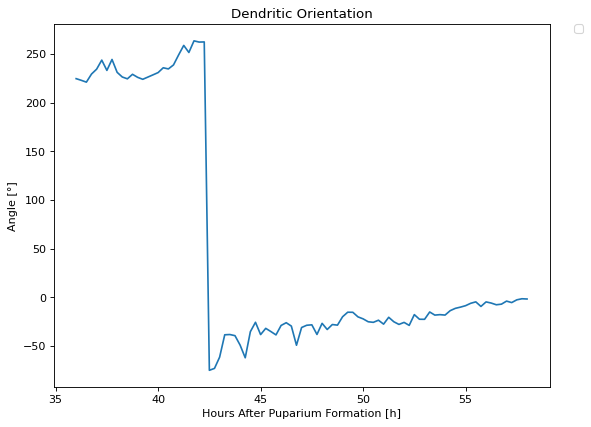

In [9]:
fig_name = save_path+save_name+'_Vect_Deg.pdf'
plt.figure(figsize=(8, 6), dpi=80)
y = output_results.ori_vec_deg[:] - 90
plt.plot(output_results.timepoints[:],y)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Dendritic Orientation')
plt.ylabel('Angle [°]')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')

In [3]:
Cols = col_zip(cols_path)
## you might want to subset either neuron, Columns or both
# neuron = neuron[:,:40]


100%|██████████| 18/18 [00:50<00:00,  2.80s/it]


<Figure size 640x480 with 0 Axes>

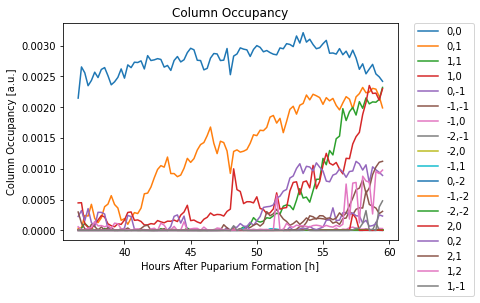

<Figure size 640x480 with 0 Axes>

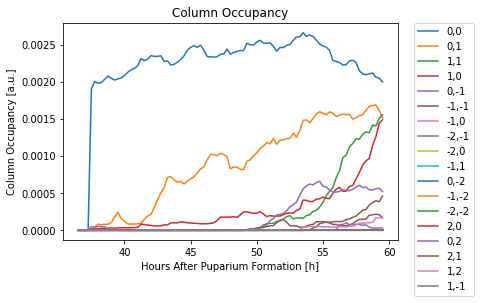

In [8]:
# calculate columns' occupancy
# define the neuron and saving name
cols_hist = analysis.col_occupancy(neuron, cols_zip=Cols, norm_cols=Cols, 
                                    normalize_cols=True, nor_fact=nor_fact, 
                                    start_t=start_age, 
                                    plot=True, save=True, 
                                    save_path=save_path, 
                                    save_file='all_px_'+save_name)

cols_hist = analysis.col_occupancy(stable_neuron, cols_zip=Cols, norm_cols=Cols, 
                                    normalize_cols=True, nor_fact=nor_fact, 
                                    start_t=start_age, 
                                    plot=True, save=True, 
                                    save_path=save_path, 
                                    save_file='stab_px_'+save_name)

In [10]:
# run this if you already calculated stable_neuron
# stable_n = tif.imread(stable_path)

# or calculate stable pixels with the following command
lifetimes = analysis.cal_lifetimes(neuron, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)
stable_neuron = analysis.stable_N(lifetimes, stab_limit=stab_limit, save=False, 
                                    save_path=save_path, save_file=save_name, 
                                    xy_pixel=0.076, z_pixel=0.4)

stable_neuron[stable_neuron !=0] = 1

# in case you want to save the neuron
stable_neuron = stable_neuron.astype('uint16')
tif.imwrite(save_path+'stable'+save_name, stable_neuron, imagej=True, resolution=(1./0.076, 1./0.076),
                metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})

100%|██████████| 92/92 [00:04<00:00, 22.43it/s]


In [6]:
# stable_neuron[stable_neuron !=0] = 1
# transient = neuron - stable_neuron
# tif.imwrite(save_path+'trans'+save_name, transient, imagej=True, resolution=(1./0.076, 1./0.076),
#                 metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})

In [7]:
tif.imwrite(save_path+'all'+save_name, neuron, imagej=True, resolution=(1./0.076, 1./0.076),
                metadata={'spacing': 0.4, 'unit': 'um', 'finterval': 1/10,'axes': 'TZYX'})

In [8]:
test = np.argwhere(stable_neuron[10])

In [15]:
len(test)

186595

In [22]:
np.linalg.norm(test.sum(axis=0))

53956008.5969907

In [28]:
np.linalg.norm(test, axis=0).sum()

190715.601078712

In [24]:
np.linalg.norm(test.sum(axis=0))/np.linalg.norm(test, axis=1).sum()

0.988230464751512

In [17]:
output_results.head()

,timepoints,vol_all,vol_stable,vol_all1,growthR_stable,trans_per,ori_vec,Max_Vec_length,av_vect,av_vect_length,ori_vec_deg,deg_variance,DGI
0,36.00,238642,0.0,238642.0,NaN,inf,"[-3583503.0, -249966.0, -3969276.0]","[59.70762095411272, 58.855755878248644, 58.008...","[-15.016292254893333, -1.0474562208505662, -16...",22.432952,[92.67627056108176],1021.807507,0.392797
1,36.25,242836,0.0,242836.0,NaN,inf,"[-3646894.0, -124134.0, -3747210.0]","[63.773035054010094, 62.91263784010332, 62.056...","[-15.017991640414273, -0.5111866081907468, -15...",21.538804,[91.3599448369784],1025.461221,0.377189
2,36.50,242873,0.0,242873.0,NaN,inf,"[-3703381.0, 126332.0, -4028465.0]","[56.480084985771754, 55.65069631190611, 54.827...","[-15.248283046213643, 0.5201587667577984, -16....",22.536682,[88.6774651077892],1077.904705,0.398348
3,36.75,255349,0.0,255349.0,NaN,inf,"[-3898799.0, -115182.0, -3743907.0]","[51.40038910358559, 53.60970061472084, 52.8109...","[-15.268570734840296, -0.4510785281263217, -14...",21.173246,[91.22073163397468],1099.646936,0.369841
4,37.00,271908,135958.0,271908.0,1.0,0.999941,"[-3303274.0, -609065.0, -2923928.0]","[68.14690014960328, 67.23838189605696, 69.0072...","[-12.148543435807095, -2.2399754327766477, -10...",16.378048,[97.86080546961483],1164.403460,0.276918


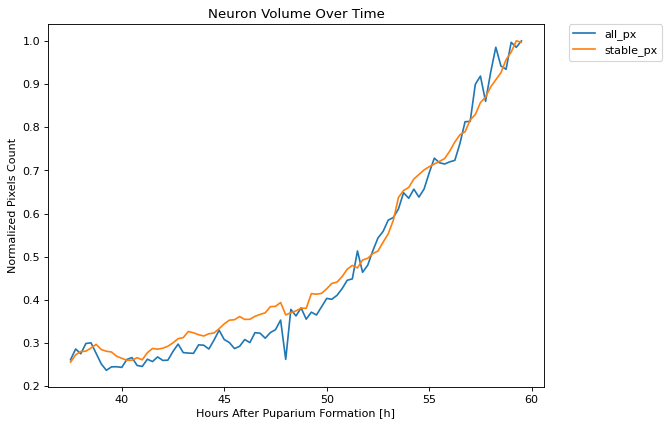

In [9]:
fig_name = save_path+save_name+'_Volume.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints[4:],output_results.vol_all[4:]/output_results.vol_all.max(), label='all_px')
plt.plot(output_results.timepoints[4:],output_results.vol_stable[4:]/output_results.vol_stable.max(), label='stable_px')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Neuron Volume Over Time')
plt.ylabel('Normalized Pixels Count')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


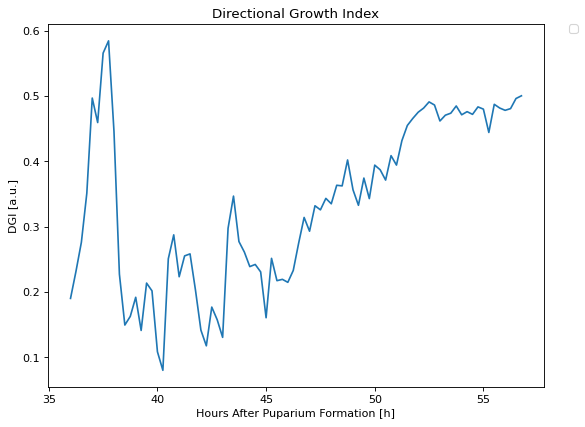

In [ ]:
fig_name = save_path+save_name+'_DGI.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints,output_results.DGI)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Directional Growth Index')
plt.ylabel('DGI [a.u.]')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


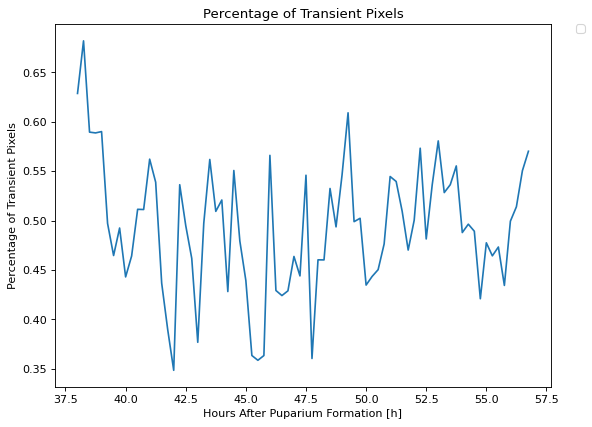

In [13]:
fig_name = save_path+save_name+'_trans_per.pdf'
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(output_results.timepoints[8:],output_results.trans_per[8:])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Percentage of Transient Pixels')
plt.ylabel('Percentage of Transient Pixels')
plt.xlabel("Hours After Puparium Formation [h]")
plt.savefig(fig_name, bbox_inches='tight')